In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.models import Model
from keras.preprocessing import image
import cv2
import tensorflow as tf
import torchvision
import torch

from keras.callbacks import ModelCheckpoint

In [2]:
tf.__version__

'2.8.0'

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices() 

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 19846893339216967
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4162256896
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10367943418753262249
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [4]:
tf.test.is_gpu_available()
#tf.config.list_physical_devices('GPU')
#tf.test.gpu_device_name()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [6]:
train_path = "D:\\wikiart_train\\"
test_path = "D:\\wikiart_valid\\"


# Run inference on CPU
with tf.device('/cpu:0'):
    trainData = []
    for filename in os.listdir(train_path):
        if filename.endswith(".jpg") or filename.endswith(".JPG") or filename.endswith(".PNG"):
            img = image.load_img(train_path+filename, target_size=(128, 128))
            trainData.append(image.img_to_array(img))
    trainData = np.array(trainData)

    testData = []
    for filename in os.listdir(test_path):
        if filename.endswith(".jpg") or filename.endswith(".JPG") or filename.endswith(".PNG"):
            img = image.load_img(test_path+filename, target_size=(128, 128))
            testData.append(image.img_to_array(img))
    testData = np.array(testData)

In [7]:
print(trainData.shape)
print(testData.shape)

(9636, 128, 128, 3)
(2034, 128, 128, 3)


In [8]:
def show_data(X, n=10, title=""):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        plt.imshow(image.array_to_img(X[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle(title, fontsize = 20)

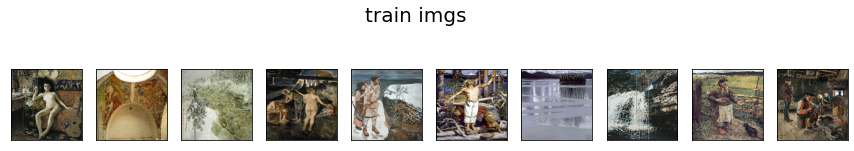

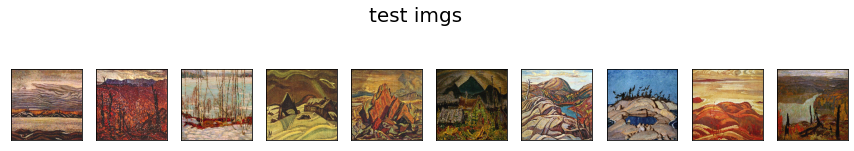

In [9]:
show_data(trainData, title="train imgs")
show_data(testData, title="test imgs")

## Model


In [10]:
input_layer = Input(shape=(128, 128, 3), name="INPUT")
x = Conv2D(64, (3, 3), padding='same')(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

code_layer = MaxPooling2D((2, 2), name="CODE")(x)

x = Conv2D(16, (3, 3), padding='same')(code_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), padding='same')(x)
x = BatchNormalization()(x)

output_layer = Conv2D(3, (3, 3), padding='same', name="OUTPUT")(x)

In [11]:
AE = Model(input_layer, output_layer)
AE.compile(optimizer='adam', loss='mse')
AE.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (InputLayer)          [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464 

In [12]:
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)


with tf.device('/cpu:0'):
    AE.fit(trainData[:4800], trainData[:4800],
                    epochs=25,
                    batch_size=10,
                    shuffle=True,
                    validation_data=(testData[:1200], testData[:1200]),
                    callbacks=[checkpoint])

Epoch 1/25
347/480 [====================>.........] - ETA: 1:30 - loss: 21043.1973

In [ ]:
AE.save("AE.h5")

NameError: name 'AE' is not defined

In [ ]:
AE.load_weights('best_model.hdf5')

## Test Model


In [ ]:
encoded_model = Model(inputs=AE.input, outputs=AE.get_layer("CODE").output)

print(encoded_model.output)
print(encoded_model.output.shape)

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 16), dtype=tf.float32, name=None), name='CODE/MaxPool:0', description="created by layer 'CODE'")
(None, 28, 28, 16)


In [ ]:
#encoded_img = encoded_model.predict(testData)
#encoded_img = encoded_img.reshape((len(testData), 28*28*8))
#encoded_img.shape

ValueError: cannot reshape array of size 539392 into shape (43,6272)

In [ ]:
reconstructed_imgs = AE.predict(testData)

print(reconstructed_imgs.shape)

(2034, 224, 224, 3)


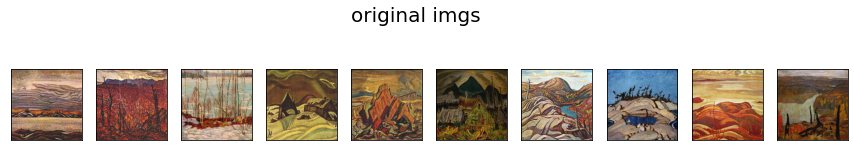

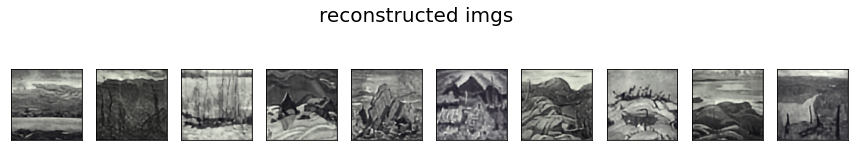

In [ ]:
show_data(testData, title="original imgs")
#show_data(encoded_cat, title="encoded cats")
show_data(reconstructed_imgs, title="reconstructed imgs")

## Find Similar Products


In [ ]:
from sklearn.metrics import pairwise_distances

encoded_model = Model(inputs=AE.input, outputs=AE.get_layer("CODE").output)

print(encoded_model.output)
print(encoded_model.output.shape)



sampleImg = cv2.imread('test_images\\87.PNG')
sampleImg = cv2.resize(sampleImg, (224,224))
sampleImg = sampleImg.transpose(2,0,1).astype(np.float32)[None]

sampleImg = sampleImg.reshape(1,224,224,3)

out = encoded_model.predict(sampleImg)
out = out.reshape(1, 12544)




sampleImg2 = cv2.imread('test_images\\87.PNG')
sampleImg2 = cv2.resize(sampleImg2, (224,224))
sampleImg2 = sampleImg2.transpose(2,0,1).astype(np.float32)[None]

sampleImg2 = sampleImg2.reshape(1,224,224,3)

out2 = encoded_model.predict(sampleImg2)


out2 = out2.reshape(1, 12544)


sampleImg3 = cv2.imread('test_images\\person.jpg')
sampleImg3 = cv2.resize(sampleImg3, (224,224))
sampleImg3 = sampleImg3.transpose(2,0,1).astype(np.float32)[None]

sampleImg3 = sampleImg3.reshape(1,224,224,3)

out3 = encoded_model.predict(sampleImg3)


out3 = out3.reshape(1, 12544)





pairwise_dist_same = pairwise_distances(out2, out)
pairwise_dist_diff = pairwise_distances(out3, out)

print("same image", pairwise_dist_same.flatten())

print("diff image", pairwise_dist_diff.flatten())


KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 16), dtype=tf.float32, name=None), name='CODE/MaxPool:0', description="created by layer 'CODE'")
(None, 28, 28, 16)
same image [1.4774259e-05]
diff image [160.88316]


#### Dataset

In [ ]:
metaID = []
metaPath = []

for root, dirs, filenames in os.walk('gallery_data'):
    for filename in filenames:
        first, last = os.path.splitext(filename)
        if last != '.PNG' or not first.isdigit():
            continue
        
        path = os.path.join(root, filename)

        metaID.append(first)
        metaPath.append(path)    

#print(metaID)
#print(metaPath)

dataset = list(zip(metaID, metaPath))
print(dataset)

[('1', 'gallery_data\\dankook\\1.PNG'), ('10', 'gallery_data\\dankook\\10.PNG'), ('2', 'gallery_data\\dankook\\2.PNG'), ('3', 'gallery_data\\dankook\\3.PNG'), ('4', 'gallery_data\\dankook\\4.PNG'), ('5', 'gallery_data\\dankook\\5.PNG'), ('6', 'gallery_data\\dankook\\6.PNG'), ('7', 'gallery_data\\dankook\\7.PNG'), ('8', 'gallery_data\\dankook\\8.PNG'), ('9', 'gallery_data\\dankook\\9.PNG'), ('11', 'gallery_data\\dongguk\\11.PNG'), ('12', 'gallery_data\\dongguk\\12.PNG'), ('13', 'gallery_data\\dongguk\\13.PNG'), ('14', 'gallery_data\\dongguk\\14.PNG'), ('15', 'gallery_data\\dongguk\\15.PNG'), ('16', 'gallery_data\\dongguk\\16.PNG'), ('17', 'gallery_data\\dongguk\\17.PNG'), ('18', 'gallery_data\\dongguk\\18.PNG'), ('19', 'gallery_data\\dongguk\\19.PNG'), ('20', 'gallery_data\\dongguk\\20.PNG'), ('21', 'gallery_data\\dongguk_women\\21.PNG'), ('22', 'gallery_data\\dongguk_women\\22.PNG'), ('23', 'gallery_data\\dongguk_women\\23.PNG'), ('24', 'gallery_data\\dongguk_women\\24.PNG'), ('25', 'g

#### Feature Extraction

In [ ]:
def extract_features(model, dataset):
    feature_list = []
    for (a,b) in dataset:
        sampleImg = cv2.imread(b)
        sampleImg = cv2.resize(sampleImg, (224,224))
        sampleImg = sampleImg.transpose(2,0,1).astype(np.float32)[None]

        sampleImg = sampleImg.reshape(1,224,224,3)

        out = encoded_model.predict(sampleImg)
        out = out.reshape(1, 12544)

        feature_list.append((a,out))

    return feature_list
        
feature_list = extract_features(encoded_model, dataset)

In [ ]:
print(len(feature_list))

100


#### Make Recommendations

In [ ]:
def get_similar_pictures(feature, feature_list, num_results):
    pdists = []

    for i in range(len(feature_list)):
        
        id = feature_list[i][0]
        dist = pairwise_distances(feature_list[i][1], feature.reshape(1,-1)).flatten()

        pdists.append((id, dist))

    pdists = sorted(pdists, key=lambda x: x[1])

    recommendations = pdists[0:num_results]

    return recommendations

In [ ]:
def find_feature(img_path):
    sampleImg = cv2.imread(img_path)
    sampleImg = cv2.resize(sampleImg, (224,224))
    sampleImg = sampleImg.transpose(2,0,1).astype(np.float32)[None]

    sampleImg = sampleImg.reshape(1,224,224,3)

    out = encoded_model.predict(sampleImg)
    out = out.reshape(1, 12544)

    return out

[('47', array([95.68914], dtype=float32)), ('23', array([103.91622], dtype=float32)), ('10', array([104.97308], dtype=float32)), ('27', array([106.601], dtype=float32)), ('22', array([108.513435], dtype=float32))]
ID =  47
Eucledian Distance =  [95.68914]


C:\Users\HUSTAR25\AppData\Local\Temp\ipykernel_7264\2950251197.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pp = np.array(recommendations)[:,0]


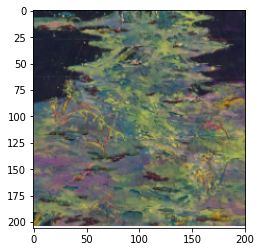

ID =  23
Eucledian Distance =  [103.91622]


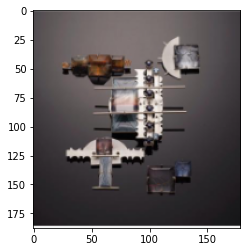

ID =  10
Eucledian Distance =  [104.97308]


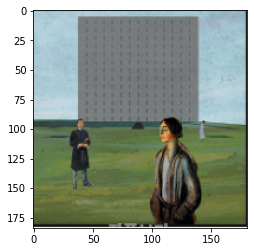

ID =  27
Eucledian Distance =  [106.601]


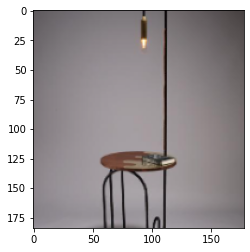

ID =  22
Eucledian Distance =  [108.513435]


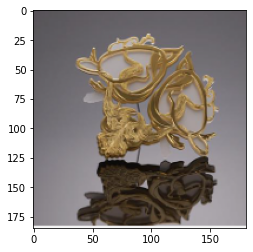

In [ ]:
input = find_feature("test_images\\test_img2.JPG")

recommendations = get_similar_pictures(input, feature_list, 5)
print(recommendations)

pp = np.array(recommendations)[:,0]

for (id, dist) in recommendations:
    for (a,b) in dataset:
        if a == id:
            print("ID = ", a)
            print("Eucledian Distance = ", dist)
            img = torchvision.io.read_image(b)
            img = img.type(torch.float32)

            plt.imshow(img.permute(1,2,0) / 255)
            plt.show()
       